In [1]:
import xlrd
import xlsxwriter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from openpyxl import load_workbook

#open excel file
predata = xlrd.open_workbook('PreRegression.xlsx')
table_predata = predata.sheets()[0]

three_factors = xlrd.open_workbook('Europe_3_Factors.xlsx')
table_3_factors = three_factors.sheets()[0]

mom_factors = xlrd.open_workbook('Europe_MOM_Factor.xlsx')
table_mom_factors = mom_factors.sheets()[0]

In [2]:
for i in range(0,table_predata.nrows):
    locals()['predata_'+str(i)] = table_predata.row_values(i)
    
#there are 3276 funds
for i in range(0,3276):
    locals()['predata_FundID_'+str(i+1)] = []
    locals()['predata_FundSize_'+str(i+1)] = []
    locals()['predata_FundFlow_'+str(i+1)] = []
    locals()['predata_FundReturn_'+str(i+1)] = []
    locals()['predata_FundSustainability_'+str(i+1)] = []
    for j in range(0,92):
        locals()['predata_FundID_'+str(i+1)].append(table_predata.row_values(1+j+i*92)[1])
        locals()['predata_FundSize_'+str(i+1)].append(table_predata.row_values(1+j+i*92)[11])
        locals()['predata_FundFlow_'+str(i+1)].append(table_predata.row_values(1+j+i*92)[12])
        locals()['predata_FundReturn_'+str(i+1)].append(table_predata.row_values(1+j+i*92)[13])
        locals()['predata_FundSustainability_'+str(i+1)].append(table_predata.row_values(1+j+i*92)[14])
        
        
#two factors excel will be saved in array        
for i in range(0,table_3_factors.nrows):
    locals()['three_factors_'+str(i)] = table_3_factors.row_values(i)     
    
for i in range(0,table_mom_factors.nrows):
    locals()['mom_factors_'+str(i)] = table_mom_factors.row_values(i)    
    
    
mkt_rf = []
smb = []
hml = []
rf = []
wml = []

for i in range(1,table_3_factors.nrows):
    mkt_rf.append(locals()['three_factors_'+str(i)][1])
    smb.append(locals()['three_factors_'+str(i)][2])
    hml.append(locals()['three_factors_'+str(i)][3])
    rf.append(locals()['three_factors_'+str(i)][4])

for i in range(1,table_mom_factors.nrows):
    wml.append(locals()['mom_factors_'+str(i)][1])

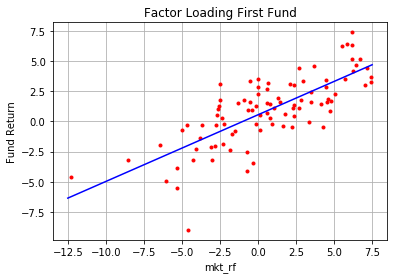

In [3]:
f_it = []
r_it = []
beta_value = []

f_it = mkt_rf

#example for how to do the regression on beta
r_it = predata_FundReturn_1

polynom1 = np.polyfit(f_it, r_it, 1)
x1 = np.linspace(-12.5, 7.5, 92)
y1 = [polynom1[0]*ix + polynom1[1] for ix in x1]
plt.cla()
plt.plot(f_it, r_it, ".r")
plt.plot(x1, y1, "-b")
plt.grid(True)
plt.title("Factor Loading First Fund")
plt.xlabel("mkt_rf")
plt.ylabel("Fund Return")
plt.pause(.5)

#Totoally 3276 beta value in the array
for i in range(1,3277):
    r_it = locals()['predata_FundReturn_'+str(i)]
    regression_1 = np.polyfit(f_it, r_it, 1)
    beta_value.append(regression_1[0])

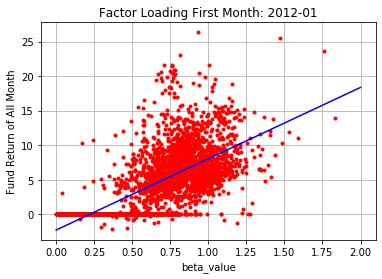

In [4]:
#split the table: totally 92 arrays, which include all Fund values in every single month
for i in range(0,92):
    locals()['return_AMFund_'+str(i+1)] = []
    
for x in range(0,92):
    for y in range(0,3276):
        locals()['return_AMFund_'+str(x+1)].append(locals()['predata_FundReturn_'+str(y+1)][x])

#example for how to do the regression on gamma

polynom2 = np.polyfit(beta_value, return_AMFund_1, 1)
x2 = np.linspace(0.0, 2.0, 3276)
y2 = [polynom2[0]*ix + polynom2[1] for ix in x2]
plt.cla()
plt.plot(beta_value, return_AMFund_1, ".r")
plt.plot(x2, y2, "-b")
plt.grid(True)
plt.title("Factor Loading First Month: 2012-01")
plt.xlabel("beta_value")
plt.ylabel("Fund Return of All Month")
plt.pause(.5)

#Totoally 92 months to caculate the gamma
gamma_value = []

for i in range(0,92):
    regression_2 = np.polyfit(beta_value, locals()['return_AMFund_'+str(i+1)], 1)
    gamma_value.append(regression_2[0])

In [5]:
#calculate the performace by (return - rf- gamma*beta)        
for i in range(0,3276):
    locals()['performance_'+str(i+1)] = []
    for j in range(0,92):
        locals()['performance_'+str(i+1)].append(locals()['predata_FundReturn_'+str(i+1)][j]-rf[j]-beta_value[i]*gamma_value[j])

In [6]:
wb = load_workbook('PreRegression.xlsx')
ws = wb.active

#write beta value into the file
ws.cell(1, 17, "Beta Value")

for i in range(0,3276):
    for j in range(0,92):
        ws.cell(i*92+j+2, 17, beta_value[i])
        
#write gamma value into the file      
ws.cell(1, 18, "Gamma Value")

for i in range(0,3276):
    for j in range(0,92):
        ws.cell(i*92+j+2, 18, gamma_value[j])
        
#write gamma times beta value into the file      
ws.cell(1, 19, "G*B Value")

for i in range(0,3276):
    for j in range(0,92):
        ws.cell(i*92+j+2, 19, beta_value[i]*gamma_value[j])
        
#write performance value into the file
ws.cell(1, 20, "Performance")

for i in range(0,3276):
    for j in range(0,92):
        ws.cell(i*92+j+2, 20, locals()['performance_'+str(i+1)][j])
        
wb.save('AfterRegression.xlsx')